### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005
        self.epsilon_min = -0.00001
        self.epsilon = 1
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)
        self.states_tracked = []

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state):
        # Write your code here:
        possible_actions_indices, actions = env.requests(state)
        
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_indices)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_indices]

            return possible_actions_indices[np.argmax(q_vals_possible)]
        

    def append_sample(self, state, action, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action_index, reward, next_state, done))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal_state = mini_batch[i]
                
                # Write your code from here
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(terminal_state)
                
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)

            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)

            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state 
        q_value = self.model.predict(self.track_state)
        
        print("States_tracked value {0}.".format(q_value[0][2]))
        
        # Grab the q_value of the action index 
        self.states_tracked.append(q_value[0][2])
        
    def save(self, name):
        self.model.save(name)

In [5]:
Episodes = 10

### DQN block

In [6]:
from Env import m
from Env import t
from Env import d

EPISODE_TIME = 24*30 #30 days before which car has to be recharged
rewards_per_episode = []
episodes = []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []
score_tracked = []

start_time = time.time()
for episode in range(Episodes):

    # Write code here
    terminal_state = False
    score = 0
    track_reward = False
    # Call the environment
    env = CabDriver(Time_matrix)
    action_space, state_space, state = env.reset()
    # Call all the initialised variables of the environment
    state = env.state_init
    total_time = 0 
    #Call the DQN agent
    state_size = m+t+d
    action_size = len(action_space)
    agent = DQNAgent(action_size=action_size, state_size=state_size)
    
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action_index = agent.get_action(state)
        action = env.action_space[action_index]
        # 2. Evaluate your reward and next state
        next_state = env.next_state_func(state, action)
        reward, step_time = env.reward_func(state, action)
        
        
        total_time += step_time
        if (total_time > EPISODE_TIME):
            # if ride does not complete in stipulated time skip
            # it and move to next episode.
            terminal_state = True
        else:
           # 3. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, terminal_state)
            # 4. Train the model by calling function agent.train_model
            agent.train_model()
            # 5. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    rewards_per_episode.append(score)
    episodes.append(episode)
        
    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="SuperCabs_car_model.h5")

    
elapsed_time = time.time() - start_time
print('Took {0}s to complete {1} episodes'.format(elapsed_time, Episodes)) 
        

2021-09-19 20:11:03.081695: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-19 20:11:03.211160: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Saving Model 0
States_tracked value 1484.732177734375.
episode 9, reward -310.0, memory_length 116, epsilon 0.9955001547284723 total_time 723.0
States_tracked value 1283.21826171875.
Took 119.9964668750763s to complete 10 episodes


### Tracking Convergence

In [7]:
agent.states_tracked

[1283.2183]

#### Q Value Convergence

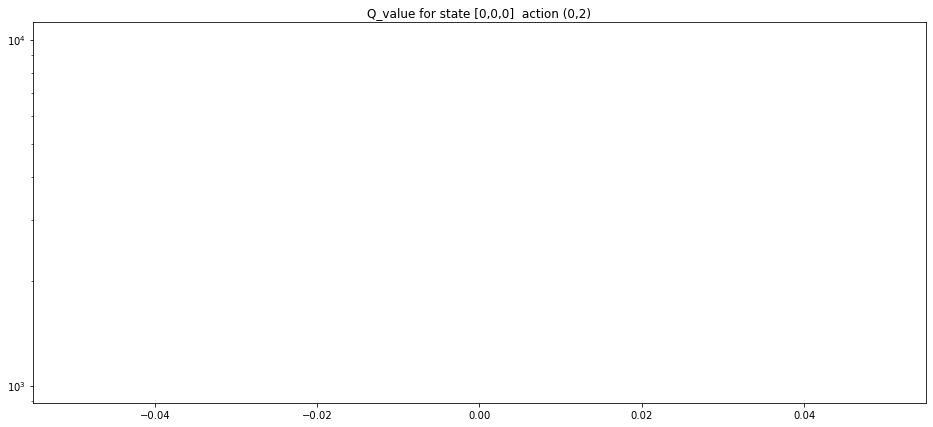

In [8]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### Tracking Rewards

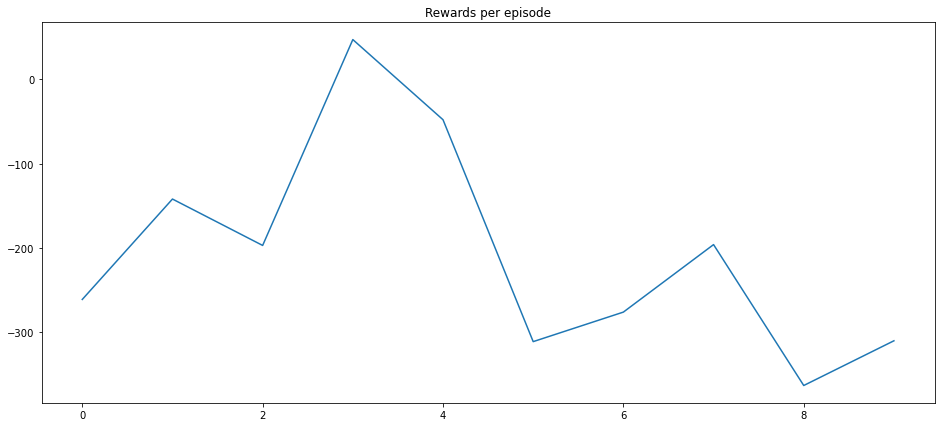

In [9]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked)))
plt.plot(xaxis,np.asarray(score_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [10]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

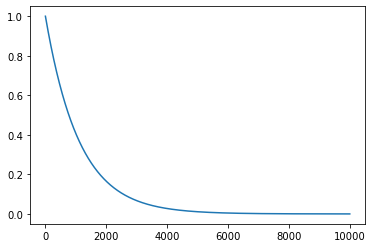

In [11]:
plt.plot(time, epsilon)
plt.show()